# train.ipynb: 用所有的训练集训练决策树
这里需要用到预处理过的数据，以减少代码运算时间。请先跑`waveform.py`。

In [1]:
import os
import multiprocessing
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.stats import kstat
from sklearn.linear_model import LinearRegression 
%matplotlib inline
from utils import loadData, getNum, getPePerWF, saveData, lossfunc_train, lossfunc_eval
from tqdm import tqdm # 展示进度条
import lightgbm as lgb # 训练决策树使用的包

`waveform.py`预处理后的数据在./train中，文件名格式为`f"final_{i}_wf.h5"`

In [2]:
trainPathRoot = './data/final-'
processedPathRoot = './train/final_'

从预处理的数据中，读取训练两个训练集需要的原始数据，并将18个训练集的数据拼接起来。
1. `intTrainWF`: 波形积分
2. `pointsPerTrainWF`: 超过阈值的点数
3. `pePerTrainWFCalc`: 每个波形对应的PE数计算值
4. `meanPeTimePerTrainWF`: 每个波形对应的PETime的手算平均值
5. `pePerTrainWF`: 每个波形对应的PE数真值
6. `wfIndices`: (n+1,)的ndarray，下标为i表示EventID=i的第一次出现在Waveform表中的下标，下标为n表示Waveform表长度

In [3]:
intTrainWF = np.array([], dtype='<i4') # 读取波形积分
pointsPerTrainWF = np.array([], dtype='<i2') # 读取超过阈值的点数
pePerTrainWFCalc = np.array([], dtype='<i2') # 读取每个波形对应的PE数计算值
meanPeTimePerTrainWF = np.array([], dtype='<f8') # 读取每个波形对应的PETime的手算平均值
pePerTrainWF = np.array([], dtype='<i2') # 读取每个波形对应的PE数真值

wfIndices = np.array([0], dtype=int)
p = np.array([], dtype='<f8')

previousIndex = 0
for i in tqdm(range(2, 20)):
    with h5py.File(f"{processedPathRoot}{i}_wf.h5", 'r') as ipt:
        intTrainWF = np.append(intTrainWF, ipt['Waveform']['intWF'][...])
        pointsPerTrainWF = np.append(pointsPerTrainWF, ipt['Waveform']['pointsPerWF'][...])
        pePerTrainWFCalc = np.append(pePerTrainWFCalc, ipt['Waveform']['pePerWFCalc'][...])
        meanPeTimePerTrainWF = np.append(meanPeTimePerTrainWF, ipt['Waveform']['meanPeTimePerWF'][...])
        pePerTrainWF = np.append(pePerTrainWF, ipt['Waveform']['pePerWF'][...])
        
        wfIndicesChunk = ipt['WfIndices'][...]
        trainPT = loadData(f"./data/final-{i}.h5", 'p')
        
        wfIndices = np.append(wfIndices, np.zeros(trainPT.shape[0]))
        p = np.append(p, np.zeros(trainPT.shape[0]))
        finalIndex = previousIndex + trainPT.shape[0] + 1
        wfIndices[previousIndex:finalIndex] = wfIndicesChunk + wfIndices[previousIndex]
        p[previousIndex:(finalIndex-1)] = trainPT['p']
        previousIndex = finalIndex-1

  6%|▌         | 1/18 [00:00<00:06,  2.82it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9137011,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6041164,), type "|V2008"> Waveform /Waveform


 11%|█         | 2/18 [00:00<00:06,  2.56it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9222643,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6021458,), type "|V2008"> Waveform /Waveform


 17%|█▋        | 3/18 [00:01<00:06,  2.44it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9009875,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5987414,), type "|V2008"> Waveform /Waveform


 22%|██▏       | 4/18 [00:01<00:05,  2.34it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9147704,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6004696,), type "|V2008"> Waveform /Waveform


 28%|██▊       | 5/18 [00:02<00:05,  2.18it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9262473,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6115519,), type "|V2008"> Waveform /Waveform


 33%|███▎      | 6/18 [00:02<00:05,  2.03it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9216927,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6075119,), type "|V2008"> Waveform /Waveform


 39%|███▉      | 7/18 [00:03<00:05,  1.91it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9103034,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5990370,), type "|V2008"> Waveform /Waveform


 44%|████▍     | 8/18 [00:03<00:05,  1.80it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9139087,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5965634,), type "|V2008"> Waveform /Waveform


 50%|█████     | 9/18 [00:04<00:05,  1.70it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9067611,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (1999,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5965655,), type "|V2008"> Waveform /Waveform


 56%|█████▌    | 10/18 [00:05<00:04,  1.60it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9219415,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6039820,), type "|V2008"> Waveform /Waveform


 61%|██████    | 11/18 [00:06<00:04,  1.51it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9141287,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5995751,), type "|V2008"> Waveform /Waveform


 67%|██████▋   | 12/18 [00:06<00:04,  1.43it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9157071,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5984516,), type "|V2008"> Waveform /Waveform


 72%|███████▏  | 13/18 [00:07<00:03,  1.35it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9191741,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (1998,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6020168,), type "|V2008"> Waveform /Waveform


 78%|███████▊  | 14/18 [00:08<00:03,  1.29it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9143911,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6038985,), type "|V2008"> Waveform /Waveform


 83%|████████▎ | 15/18 [00:09<00:02,  1.23it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9219236,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (1999,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6039233,), type "|V2008"> Waveform /Waveform


 89%|████████▉ | 16/18 [00:10<00:01,  1.17it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9104863,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5981409,), type "|V2008"> Waveform /Waveform


 94%|█████████▍| 17/18 [00:11<00:00,  1.12it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9202609,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6058586,), type "|V2008"> Waveform /Waveform


100%|██████████| 18/18 [00:12<00:00,  1.46it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9261569,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6085040,), type "|V2008"> Waveform /Waveform


下面的代码和`model.ipynb`是完全一样的，除了训练集、验证集大小不一样。

In [9]:
'''
trainDataForPePerWF = lgb.Dataset(
     np.stack(
        (intTrainWF[:-10000000], pointsPerTrainWF[:-10000000], pePerTrainWFCalc[:-10000000]),
        axis=1
    ),
    label=pePerTrainWF[:-10000000],
)
validationDataForPePerWF = lgb.Dataset(
    np.stack(
        (intTrainWF[-10000000:], pointsPerTrainWF[-10000000:], pePerTrainWFCalc[-10000000:]),
        axis=1
    ),
    label=pePerTrainWF[-10000000:],
    reference=trainDataForPePerWF,
)
trainDataForPePerWF.save_binary('./train/trainPePerWF.bin')
validationDataForPePerWF.save_binary('./train/validPePerWF.bin')
'''

[LightGBM] [Info] Saving data to binary file ./train/trainPePerWF.bin


/home/zhaohaimeng/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


[LightGBM] [Info] Saving data to binary file ./train/validPePerWF.bin


In [10]:
'''
trainDataForPePerWF = lgb.Dataset('./train/trainPePerWF.bin')
validationDataForPePerWF = lgb.Dataset('./train/validPePerWF.bin', reference=trainDataForPePerWF)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 2**11,
    'learning_rate': 0.01,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'verbose': 0,
    'num_threads': 20,
    'max_depth': 20,
}
gbmForPePerWF = lgb.train(
    params,
    trainDataForPePerWF,
    num_boost_round=3000,
    valid_sets=validationDataForPePerWF,
    early_stopping_rounds=100,
)
gbmForPePerWF.save_model('model/modelPePerWF.txt')
'''

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.465467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's rmse: 1.82572
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 1.80789
[3]	valid_0's rmse: 1.79023
[4]	valid_0's rmse: 1.77276
[5]	valid_0's rmse: 1.75547
[6]	valid_0's rmse: 1.73836
[7]	valid_0's rmse: 1.72142
[8]	valid_0's rmse: 1.70466
[9]	valid_0's rmse: 1.68806
[10]	valid_0's rmse: 1.67164
[11]	valid_0's rmse: 1.65539
[12]	valid_0's rmse: 1.6393
[13]	valid_0's rmse: 1.62338
[14]	valid_0's rmse: 1.60763
[15]	valid_0's rmse: 1.59203
[16]	valid_0's rmse: 1.5766
[17]	valid_0's rmse: 1.56132
[18]	valid_0's rmse: 1.54621
[19]	valid_0's rmse: 1.53124
[20]	valid_0's rmse: 1.51644
[21]	valid_0's rmse: 1.50178
[22]	valid_0's rmse: 1.48728
[23]	valid_0's rmse: 1.47293
[24]	valid_0's rmse: 1.45873
[25]	valid_0's rmse: 1.4

[263]	valid_0's rmse: 0.306831
[264]	valid_0's rmse: 0.306286
[265]	valid_0's rmse: 0.305752
[266]	valid_0's rmse: 0.305227
[267]	valid_0's rmse: 0.304712
[268]	valid_0's rmse: 0.304206
[269]	valid_0's rmse: 0.303709
[270]	valid_0's rmse: 0.303222
[271]	valid_0's rmse: 0.302743
[272]	valid_0's rmse: 0.302273
[273]	valid_0's rmse: 0.301812
[274]	valid_0's rmse: 0.30136
[275]	valid_0's rmse: 0.300916
[276]	valid_0's rmse: 0.30048
[277]	valid_0's rmse: 0.300052
[278]	valid_0's rmse: 0.299632
[279]	valid_0's rmse: 0.29922
[280]	valid_0's rmse: 0.298815
[281]	valid_0's rmse: 0.298418
[282]	valid_0's rmse: 0.298029
[283]	valid_0's rmse: 0.297646
[284]	valid_0's rmse: 0.297271
[285]	valid_0's rmse: 0.296903
[286]	valid_0's rmse: 0.296542
[287]	valid_0's rmse: 0.296188
[288]	valid_0's rmse: 0.29584
[289]	valid_0's rmse: 0.295498
[290]	valid_0's rmse: 0.295164
[291]	valid_0's rmse: 0.294835
[292]	valid_0's rmse: 0.294513
[293]	valid_0's rmse: 0.294197
[294]	valid_0's rmse: 0.293886
[295]	valid_

[529]	valid_0's rmse: 0.278409
[530]	valid_0's rmse: 0.278406
[531]	valid_0's rmse: 0.278404
[532]	valid_0's rmse: 0.278402
[533]	valid_0's rmse: 0.278399
[534]	valid_0's rmse: 0.278397
[535]	valid_0's rmse: 0.278395
[536]	valid_0's rmse: 0.278392
[537]	valid_0's rmse: 0.27839
[538]	valid_0's rmse: 0.278388
[539]	valid_0's rmse: 0.278386
[540]	valid_0's rmse: 0.278384
[541]	valid_0's rmse: 0.278382
[542]	valid_0's rmse: 0.27838
[543]	valid_0's rmse: 0.278378
[544]	valid_0's rmse: 0.278376
[545]	valid_0's rmse: 0.278374
[546]	valid_0's rmse: 0.278373
[547]	valid_0's rmse: 0.278371
[548]	valid_0's rmse: 0.278369
[549]	valid_0's rmse: 0.278368
[550]	valid_0's rmse: 0.278366
[551]	valid_0's rmse: 0.278364
[552]	valid_0's rmse: 0.278363
[553]	valid_0's rmse: 0.278361
[554]	valid_0's rmse: 0.27836
[555]	valid_0's rmse: 0.278358
[556]	valid_0's rmse: 0.278357
[557]	valid_0's rmse: 0.278356
[558]	valid_0's rmse: 0.278354
[559]	valid_0's rmse: 0.278353
[560]	valid_0's rmse: 0.278352
[561]	valid

In [13]:
'''
gbmForPePerWF = lgb.Booster(model_file='./modelPePerWF.txt')
pePerTrainWFFinal = gbmForPePerWF.predict(
    np.stack(
        (intTrainWF, pointsPerTrainWF, pePerTrainWFCalc),
        axis=1
    )
)
'''

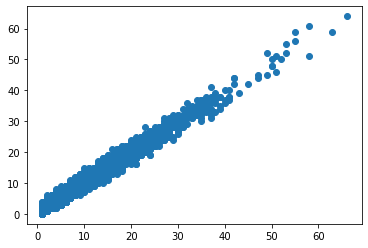

In [32]:
'''
model = LinearRegression()
model.fit(intTrainWF.reshape(-1, 1), pePerTrainWF)
pePerTrainWFInt = np.round(model.predict(intTrainWF.reshape(-1,1)))
plt.scatter(pePerTrainWFInt[:600000], pePerTrainWF[:600000])
plt.show()
'''

In [41]:
'''
print(model.coef_)
print(model.intercept_)
'''

[0.00651683]
0.5644330147776138


In [4]:
# splitPePerTrainWFFinal = np.split(pePerTrainWFFinal, wfIndices[1:-1].astype(int))
splitPePerTrainWFFinal = np.split(pePerTrainWFCalc, wfIndices[1:-1].astype(int))
peTotal = np.empty(p.shape[0])
peMean = np.empty(p.shape[0])
peStd = np.empty(p.shape[0])
#peCu3 = np.empty(p.shape[0])
#peCu4 = np.empty(p.shape[0])
for index, pePerTrainWFFinalChunk in enumerate(tqdm(splitPePerTrainWFFinal)):
    peTotal[index] = np.sum(pePerTrainWFFinalChunk)
    peMean[index] = np.mean(pePerTrainWFFinalChunk)
    peStd[index] = np.std(pePerTrainWFFinalChunk)
    #peCu3[index] = kstat(pePerTrainWFFinalChunk[~np.isnan(pePerTrainWFFinalChunk)], 3)
    #peCu4[index] = kstat(pePerTrainWFFinalChunk[~np.isnan(pePerTrainWFFinalChunk)], 4)

splitMeanPeTimePerTrainWF = np.split(meanPeTimePerTrainWF, wfIndices[1:-1].astype(int))
peTimeMean = np.empty(p.shape[0])
peTimeStd = np.empty(p.shape[0])
#peTimeCu3 = np.empty(p.shape[0])
#peTimeCu4 = np.empty(p.shape[0])
for index, meanPeTimePerTrainWFFinalChunk in enumerate(tqdm(splitMeanPeTimePerTrainWF)):
    peTimeMean[index] = np.nanmean(meanPeTimePerTrainWFFinalChunk)
    peTimeStd[index] = np.nanstd(meanPeTimePerTrainWFFinalChunk)
    #peTimeCu3[index] = kstat(meanPeTimePerTrainWFFinalChunk[~np.isnan(meanPeTimePerTrainWFFinalChunk)], 3)
    #peTimeCu4[index] = kstat(meanPeTimePerTrainWFFinalChunk[~np.isnan(meanPeTimePerTrainWFFinalChunk)], 4)    

100%|██████████| 35996/35996 [00:31<00:00, 1125.37it/s]


In [15]:
trainDataForP = lgb.Dataset(
    np.stack(
        (#peTotal[:-3600],
         peMean[:-3600],
         peStd[:-3600],
         #peCu3[:-3600],
         #peCu4[:-3600],
         peTimeMean[:-3600],
         peTimeStd[:-3600],
         #peTimeCu3[:-3600],
         #peTimeCu4[:-3600],
        ),
        axis=1
    ),
    label=p[:-3600]/peTotal[:-3600]
)
validationDataForP = lgb.Dataset(
    np.stack(
        (#peTotal[-3600:],
         peMean[-3600:],
         peStd[-3600:],
         #peCu3[-3600:],
         #peCu4[-3600:],
         peTimeMean[-3600:],
         peTimeStd[-3600:],
         #peTimeCu3[-3600:],
         #peTimeCu4[-3600:],
        ),
        axis=1
    ),
    label=p[-3600:]/peTotal[-3600:],
    reference=trainDataForP
)
trainDataPath = './train/trainDataForP.bin'
validDataPath = './train/validDataForP.bin'
if os.path.exists(trainDataPath):
    os.remove(trainDataPath)
if os.path.exists(validDataPath):
    os.remove(validDataPath)
trainDataForP.save_binary('./train/trainDataForP.bin')
validationDataForP.save_binary('./train/validDataForP.bin')

[LightGBM] [Info] Saving data to binary file ./train/trainDataForP.bin
[LightGBM] [Info] Saving data to binary file ./train/validDataForP.bin


In [16]:
trainDataForP = lgb.Dataset('./train/trainDataForP.bin')
validationDataForP = lgb.Dataset('./train/validDataForP.bin')

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'custom'},
    'num_leaves': 2**12,
    'learning_rate': 0.001,
    'feature_fraction': 1,
    'bagging_fraction': 0.1,
    'bagging_freq': 5,
    'verbose': -1,
    'num_threads': 20,
    'max_depth': 12,
    #'device': 'gpu',
    #'gpu_platform_id': -1,
    #'gpu_device_id': -1,
}
gbmForP = lgb.train(
    params,
    trainDataForP,
    num_boost_round=60000,
    valid_sets=validationDataForP,
    early_stopping_rounds=1000,
    fobj=lossfunc_train,
    feval=lossfunc_eval,
)
gbmForP.save_model('model/modelPCalc.txt')

[1]	valid_0's custom: 0.00122512
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's custom: 0.00122268
[3]	valid_0's custom: 0.00122024
[4]	valid_0's custom: 0.00121781
[5]	valid_0's custom: 0.00121538
[6]	valid_0's custom: 0.00121296
[7]	valid_0's custom: 0.00121055
[8]	valid_0's custom: 0.00120814
[9]	valid_0's custom: 0.00120574
[10]	valid_0's custom: 0.00120334
[11]	valid_0's custom: 0.00120094
[12]	valid_0's custom: 0.00119856
[13]	valid_0's custom: 0.00119617
[14]	valid_0's custom: 0.00119379
[15]	valid_0's custom: 0.00119142
[16]	valid_0's custom: 0.00118905
[17]	valid_0's custom: 0.00118668
[18]	valid_0's custom: 0.00118432
[19]	valid_0's custom: 0.00118197
[20]	valid_0's custom: 0.00117962
[21]	valid_0's custom: 0.00117727
[22]	valid_0's custom: 0.00117493
[23]	valid_0's custom: 0.00117259
[24]	valid_0's custom: 0.00117025
[25]	valid_0's custom: 0.00116793
[26]	valid_0's custom: 0.00116561
[27]	valid_0's custom: 0.00116329
[28]	valid_0's custom: 0.001

[249]	valid_0's custom: 0.000747933
[250]	valid_0's custom: 0.000746446
[251]	valid_0's custom: 0.000744965
[252]	valid_0's custom: 0.000743488
[253]	valid_0's custom: 0.000742014
[254]	valid_0's custom: 0.000740542
[255]	valid_0's custom: 0.000739074
[256]	valid_0's custom: 0.000737609
[257]	valid_0's custom: 0.000736148
[258]	valid_0's custom: 0.000734689
[259]	valid_0's custom: 0.000733233
[260]	valid_0's custom: 0.00073178
[261]	valid_0's custom: 0.00073033
[262]	valid_0's custom: 0.000728883
[263]	valid_0's custom: 0.000727439
[264]	valid_0's custom: 0.000725998
[265]	valid_0's custom: 0.00072456
[266]	valid_0's custom: 0.000723123
[267]	valid_0's custom: 0.00072169
[268]	valid_0's custom: 0.000720258
[269]	valid_0's custom: 0.00071883
[270]	valid_0's custom: 0.000717405
[271]	valid_0's custom: 0.000715982
[272]	valid_0's custom: 0.000714563
[273]	valid_0's custom: 0.000713146
[274]	valid_0's custom: 0.000711732
[275]	valid_0's custom: 0.000710321
[276]	valid_0's custom: 0.0007089

[498]	valid_0's custom: 0.000456596
[499]	valid_0's custom: 0.000455692
[500]	valid_0's custom: 0.000454791
[501]	valid_0's custom: 0.000453892
[502]	valid_0's custom: 0.000452996
[503]	valid_0's custom: 0.000452101
[504]	valid_0's custom: 0.000451208
[505]	valid_0's custom: 0.000450317
[506]	valid_0's custom: 0.000449425
[507]	valid_0's custom: 0.000448535
[508]	valid_0's custom: 0.000447647
[509]	valid_0's custom: 0.000446761
[510]	valid_0's custom: 0.000445877
[511]	valid_0's custom: 0.000444996
[512]	valid_0's custom: 0.000444117
[513]	valid_0's custom: 0.000443239
[514]	valid_0's custom: 0.000442364
[515]	valid_0's custom: 0.000441491
[516]	valid_0's custom: 0.000440619
[517]	valid_0's custom: 0.000439748
[518]	valid_0's custom: 0.00043888
[519]	valid_0's custom: 0.000438013
[520]	valid_0's custom: 0.000437148
[521]	valid_0's custom: 0.000436284
[522]	valid_0's custom: 0.000435423
[523]	valid_0's custom: 0.000434562
[524]	valid_0's custom: 0.000433704
[525]	valid_0's custom: 0.000

[749]	valid_0's custom: 0.000278429
[750]	valid_0's custom: 0.000277882
[751]	valid_0's custom: 0.000277336
[752]	valid_0's custom: 0.000276791
[753]	valid_0's custom: 0.000276247
[754]	valid_0's custom: 0.000275704
[755]	valid_0's custom: 0.000275162
[756]	valid_0's custom: 0.000274623
[757]	valid_0's custom: 0.000274085
[758]	valid_0's custom: 0.000273549
[759]	valid_0's custom: 0.000273014
[760]	valid_0's custom: 0.000272479
[761]	valid_0's custom: 0.000271946
[762]	valid_0's custom: 0.000271414
[763]	valid_0's custom: 0.000270883
[764]	valid_0's custom: 0.000270354
[765]	valid_0's custom: 0.000269825
[766]	valid_0's custom: 0.000269294
[767]	valid_0's custom: 0.000268765
[768]	valid_0's custom: 0.000268236
[769]	valid_0's custom: 0.000267709
[770]	valid_0's custom: 0.000267182
[771]	valid_0's custom: 0.000266659
[772]	valid_0's custom: 0.000266138
[773]	valid_0's custom: 0.000265617
[774]	valid_0's custom: 0.000265097
[775]	valid_0's custom: 0.000264578
[776]	valid_0's custom: 0.00

[1001]	valid_0's custom: 0.00017032
[1002]	valid_0's custom: 0.000169991
[1003]	valid_0's custom: 0.000169663
[1004]	valid_0's custom: 0.000169335
[1005]	valid_0's custom: 0.000169008
[1006]	valid_0's custom: 0.000168681
[1007]	valid_0's custom: 0.000168354
[1008]	valid_0's custom: 0.000168028
[1009]	valid_0's custom: 0.000167703
[1010]	valid_0's custom: 0.000167378
[1011]	valid_0's custom: 0.000167054
[1012]	valid_0's custom: 0.00016673
[1013]	valid_0's custom: 0.000166407
[1014]	valid_0's custom: 0.000166084
[1015]	valid_0's custom: 0.000165762
[1016]	valid_0's custom: 0.000165441
[1017]	valid_0's custom: 0.00016512
[1018]	valid_0's custom: 0.0001648
[1019]	valid_0's custom: 0.000164481
[1020]	valid_0's custom: 0.000164162
[1021]	valid_0's custom: 0.000163844
[1022]	valid_0's custom: 0.000163526
[1023]	valid_0's custom: 0.000163209
[1024]	valid_0's custom: 0.000162892
[1025]	valid_0's custom: 0.000162577
[1026]	valid_0's custom: 0.000162263
[1027]	valid_0's custom: 0.000161951
[1028]

[1259]	valid_0's custom: 0.000103816
[1260]	valid_0's custom: 0.000103619
[1261]	valid_0's custom: 0.000103423
[1262]	valid_0's custom: 0.000103228
[1263]	valid_0's custom: 0.000103033
[1264]	valid_0's custom: 0.000102839
[1265]	valid_0's custom: 0.000102645
[1266]	valid_0's custom: 0.00010245
[1267]	valid_0's custom: 0.000102257
[1268]	valid_0's custom: 0.000102063
[1269]	valid_0's custom: 0.00010187
[1270]	valid_0's custom: 0.000101677
[1271]	valid_0's custom: 0.000101485
[1272]	valid_0's custom: 0.000101293
[1273]	valid_0's custom: 0.000101102
[1274]	valid_0's custom: 0.000100911
[1275]	valid_0's custom: 0.000100721
[1276]	valid_0's custom: 0.00010053
[1277]	valid_0's custom: 0.000100339
[1278]	valid_0's custom: 0.000100149
[1279]	valid_0's custom: 9.99592e-05
[1280]	valid_0's custom: 9.97698e-05
[1281]	valid_0's custom: 9.95818e-05
[1282]	valid_0's custom: 9.93942e-05
[1283]	valid_0's custom: 9.9207e-05
[1284]	valid_0's custom: 9.90203e-05
[1285]	valid_0's custom: 9.88338e-05
[1286

[1523]	valid_0's custom: 6.34821e-05
[1524]	valid_0's custom: 6.33655e-05
[1525]	valid_0's custom: 6.32491e-05
[1526]	valid_0's custom: 6.31341e-05
[1527]	valid_0's custom: 6.30194e-05
[1528]	valid_0's custom: 6.29048e-05
[1529]	valid_0's custom: 6.27905e-05
[1530]	valid_0's custom: 6.26765e-05
[1531]	valid_0's custom: 6.25641e-05
[1532]	valid_0's custom: 6.24519e-05
[1533]	valid_0's custom: 6.234e-05
[1534]	valid_0's custom: 6.22283e-05
[1535]	valid_0's custom: 6.21168e-05
[1536]	valid_0's custom: 6.20033e-05
[1537]	valid_0's custom: 6.189e-05
[1538]	valid_0's custom: 6.17769e-05
[1539]	valid_0's custom: 6.1664e-05
[1540]	valid_0's custom: 6.15513e-05
[1541]	valid_0's custom: 6.14401e-05
[1542]	valid_0's custom: 6.13292e-05
[1543]	valid_0's custom: 6.12184e-05
[1544]	valid_0's custom: 6.1108e-05
[1545]	valid_0's custom: 6.09977e-05
[1546]	valid_0's custom: 6.08865e-05
[1547]	valid_0's custom: 6.07754e-05
[1548]	valid_0's custom: 6.06646e-05
[1549]	valid_0's custom: 6.05539e-05
[1550]	

[1752]	valid_0's custom: 4.22019e-05
[1753]	valid_0's custom: 4.21286e-05
[1754]	valid_0's custom: 4.20554e-05
[1755]	valid_0's custom: 4.19824e-05
[1756]	valid_0's custom: 4.19097e-05
[1757]	valid_0's custom: 4.18371e-05
[1758]	valid_0's custom: 4.17647e-05
[1759]	valid_0's custom: 4.16924e-05
[1760]	valid_0's custom: 4.16202e-05
[1761]	valid_0's custom: 4.15471e-05
[1762]	valid_0's custom: 4.14741e-05
[1763]	valid_0's custom: 4.14013e-05
[1764]	valid_0's custom: 4.13286e-05
[1765]	valid_0's custom: 4.1256e-05
[1766]	valid_0's custom: 4.11845e-05
[1767]	valid_0's custom: 4.11132e-05
[1768]	valid_0's custom: 4.10421e-05
[1769]	valid_0's custom: 4.0971e-05
[1770]	valid_0's custom: 4.09001e-05
[1771]	valid_0's custom: 4.08297e-05
[1772]	valid_0's custom: 4.07595e-05
[1773]	valid_0's custom: 4.06893e-05
[1774]	valid_0's custom: 4.06194e-05
[1775]	valid_0's custom: 4.05495e-05
[1776]	valid_0's custom: 4.04794e-05
[1777]	valid_0's custom: 4.04093e-05
[1778]	valid_0's custom: 4.03395e-05
[17

[1981]	valid_0's custom: 2.86732e-05
[1982]	valid_0's custom: 2.86266e-05
[1983]	valid_0's custom: 2.85802e-05
[1984]	valid_0's custom: 2.85339e-05
[1985]	valid_0's custom: 2.84877e-05
[1986]	valid_0's custom: 2.84428e-05
[1987]	valid_0's custom: 2.8398e-05
[1988]	valid_0's custom: 2.83532e-05
[1989]	valid_0's custom: 2.83086e-05
[1990]	valid_0's custom: 2.82639e-05
[1991]	valid_0's custom: 2.82176e-05
[1992]	valid_0's custom: 2.81713e-05
[1993]	valid_0's custom: 2.81252e-05
[1994]	valid_0's custom: 2.80791e-05
[1995]	valid_0's custom: 2.80331e-05
[1996]	valid_0's custom: 2.79879e-05
[1997]	valid_0's custom: 2.79427e-05
[1998]	valid_0's custom: 2.78976e-05
[1999]	valid_0's custom: 2.78526e-05
[2000]	valid_0's custom: 2.78077e-05
[2001]	valid_0's custom: 2.7763e-05
[2002]	valid_0's custom: 2.77183e-05
[2003]	valid_0's custom: 2.76736e-05
[2004]	valid_0's custom: 2.76292e-05
[2005]	valid_0's custom: 2.75847e-05
[2006]	valid_0's custom: 2.7541e-05
[2007]	valid_0's custom: 2.74975e-05
[200

[2224]	valid_0's custom: 1.97519e-05
[2225]	valid_0's custom: 1.97238e-05
[2226]	valid_0's custom: 1.9695e-05
[2227]	valid_0's custom: 1.96663e-05
[2228]	valid_0's custom: 1.96376e-05
[2229]	valid_0's custom: 1.9609e-05
[2230]	valid_0's custom: 1.95805e-05
[2231]	valid_0's custom: 1.95526e-05
[2232]	valid_0's custom: 1.95248e-05
[2233]	valid_0's custom: 1.94971e-05
[2234]	valid_0's custom: 1.94694e-05
[2235]	valid_0's custom: 1.94417e-05
[2236]	valid_0's custom: 1.94138e-05
[2237]	valid_0's custom: 1.93858e-05
[2238]	valid_0's custom: 1.9358e-05
[2239]	valid_0's custom: 1.93301e-05
[2240]	valid_0's custom: 1.93024e-05
[2241]	valid_0's custom: 1.9276e-05
[2242]	valid_0's custom: 1.92496e-05
[2243]	valid_0's custom: 1.92232e-05
[2244]	valid_0's custom: 1.9197e-05
[2245]	valid_0's custom: 1.91708e-05
[2246]	valid_0's custom: 1.91432e-05
[2247]	valid_0's custom: 1.91158e-05
[2248]	valid_0's custom: 1.90884e-05
[2249]	valid_0's custom: 1.9061e-05
[2250]	valid_0's custom: 1.90337e-05
[2251]	

[2471]	valid_0's custom: 1.41995e-05
[2472]	valid_0's custom: 1.41811e-05
[2473]	valid_0's custom: 1.41628e-05
[2474]	valid_0's custom: 1.41446e-05
[2475]	valid_0's custom: 1.41263e-05
[2476]	valid_0's custom: 1.41088e-05
[2477]	valid_0's custom: 1.40913e-05
[2478]	valid_0's custom: 1.40739e-05
[2479]	valid_0's custom: 1.40565e-05
[2480]	valid_0's custom: 1.40391e-05
[2481]	valid_0's custom: 1.40223e-05
[2482]	valid_0's custom: 1.40056e-05
[2483]	valid_0's custom: 1.39889e-05
[2484]	valid_0's custom: 1.39722e-05
[2485]	valid_0's custom: 1.39556e-05
[2486]	valid_0's custom: 1.39386e-05
[2487]	valid_0's custom: 1.39217e-05
[2488]	valid_0's custom: 1.39048e-05
[2489]	valid_0's custom: 1.38879e-05
[2490]	valid_0's custom: 1.38711e-05
[2491]	valid_0's custom: 1.38545e-05
[2492]	valid_0's custom: 1.3838e-05
[2493]	valid_0's custom: 1.38216e-05
[2494]	valid_0's custom: 1.38051e-05
[2495]	valid_0's custom: 1.37888e-05
[2496]	valid_0's custom: 1.37726e-05
[2497]	valid_0's custom: 1.37564e-05
[2

[2736]	valid_0's custom: 1.06258e-05
[2737]	valid_0's custom: 1.06155e-05
[2738]	valid_0's custom: 1.06052e-05
[2739]	valid_0's custom: 1.05951e-05
[2740]	valid_0's custom: 1.05848e-05
[2741]	valid_0's custom: 1.05746e-05
[2742]	valid_0's custom: 1.05645e-05
[2743]	valid_0's custom: 1.05543e-05
[2744]	valid_0's custom: 1.05442e-05
[2745]	valid_0's custom: 1.05341e-05
[2746]	valid_0's custom: 1.05236e-05
[2747]	valid_0's custom: 1.05131e-05
[2748]	valid_0's custom: 1.05027e-05
[2749]	valid_0's custom: 1.04922e-05
[2750]	valid_0's custom: 1.04818e-05
[2751]	valid_0's custom: 1.0472e-05
[2752]	valid_0's custom: 1.04622e-05
[2753]	valid_0's custom: 1.04524e-05
[2754]	valid_0's custom: 1.04427e-05
[2755]	valid_0's custom: 1.0433e-05
[2756]	valid_0's custom: 1.04229e-05
[2757]	valid_0's custom: 1.04128e-05
[2758]	valid_0's custom: 1.04027e-05
[2759]	valid_0's custom: 1.03927e-05
[2760]	valid_0's custom: 1.03826e-05
[2761]	valid_0's custom: 1.03727e-05
[2762]	valid_0's custom: 1.03628e-05
[27

[3012]	valid_0's custom: 8.44599e-06
[3013]	valid_0's custom: 8.44026e-06
[3014]	valid_0's custom: 8.43454e-06
[3015]	valid_0's custom: 8.42883e-06
[3016]	valid_0's custom: 8.42259e-06
[3017]	valid_0's custom: 8.41637e-06
[3018]	valid_0's custom: 8.41017e-06
[3019]	valid_0's custom: 8.40397e-06
[3020]	valid_0's custom: 8.39779e-06
[3021]	valid_0's custom: 8.39135e-06
[3022]	valid_0's custom: 8.38493e-06
[3023]	valid_0's custom: 8.37852e-06
[3024]	valid_0's custom: 8.37212e-06
[3025]	valid_0's custom: 8.36575e-06
[3026]	valid_0's custom: 8.3598e-06
[3027]	valid_0's custom: 8.35386e-06
[3028]	valid_0's custom: 8.34793e-06
[3029]	valid_0's custom: 8.34201e-06
[3030]	valid_0's custom: 8.33611e-06
[3031]	valid_0's custom: 8.33042e-06
[3032]	valid_0's custom: 8.32474e-06
[3033]	valid_0's custom: 8.31907e-06
[3034]	valid_0's custom: 8.31341e-06
[3035]	valid_0's custom: 8.30777e-06
[3036]	valid_0's custom: 8.30202e-06
[3037]	valid_0's custom: 8.29628e-06
[3038]	valid_0's custom: 8.29056e-06
[3

[3250]	valid_0's custom: 7.34782e-06
[3251]	valid_0's custom: 7.34458e-06
[3252]	valid_0's custom: 7.34136e-06
[3253]	valid_0's custom: 7.33813e-06
[3254]	valid_0's custom: 7.33492e-06
[3255]	valid_0's custom: 7.33172e-06
[3256]	valid_0's custom: 7.32829e-06
[3257]	valid_0's custom: 7.32487e-06
[3258]	valid_0's custom: 7.32146e-06
[3259]	valid_0's custom: 7.31805e-06
[3260]	valid_0's custom: 7.31466e-06
[3261]	valid_0's custom: 7.31083e-06
[3262]	valid_0's custom: 7.30701e-06
[3263]	valid_0's custom: 7.30319e-06
[3264]	valid_0's custom: 7.29939e-06
[3265]	valid_0's custom: 7.29559e-06
[3266]	valid_0's custom: 7.29245e-06
[3267]	valid_0's custom: 7.2893e-06
[3268]	valid_0's custom: 7.28617e-06
[3269]	valid_0's custom: 7.28304e-06
[3270]	valid_0's custom: 7.27992e-06
[3271]	valid_0's custom: 7.27717e-06
[3272]	valid_0's custom: 7.27443e-06
[3273]	valid_0's custom: 7.2717e-06
[3274]	valid_0's custom: 7.26898e-06
[3275]	valid_0's custom: 7.26627e-06
[3276]	valid_0's custom: 7.26252e-06
[32

[3505]	valid_0's custom: 6.6276e-06
[3506]	valid_0's custom: 6.62542e-06
[3507]	valid_0's custom: 6.62324e-06
[3508]	valid_0's custom: 6.62106e-06
[3509]	valid_0's custom: 6.61889e-06
[3510]	valid_0's custom: 6.61673e-06
[3511]	valid_0's custom: 6.61497e-06
[3512]	valid_0's custom: 6.61322e-06
[3513]	valid_0's custom: 6.61147e-06
[3514]	valid_0's custom: 6.60974e-06
[3515]	valid_0's custom: 6.608e-06
[3516]	valid_0's custom: 6.60576e-06
[3517]	valid_0's custom: 6.60351e-06
[3518]	valid_0's custom: 6.60128e-06
[3519]	valid_0's custom: 6.59904e-06
[3520]	valid_0's custom: 6.59682e-06
[3521]	valid_0's custom: 6.59499e-06
[3522]	valid_0's custom: 6.59317e-06
[3523]	valid_0's custom: 6.59135e-06
[3524]	valid_0's custom: 6.58954e-06
[3525]	valid_0's custom: 6.58774e-06
[3526]	valid_0's custom: 6.58608e-06
[3527]	valid_0's custom: 6.58442e-06
[3528]	valid_0's custom: 6.58276e-06
[3529]	valid_0's custom: 6.5811e-06
[3530]	valid_0's custom: 6.57945e-06
[3531]	valid_0's custom: 6.57769e-06
[3532

[3795]	valid_0's custom: 6.16422e-06
[3796]	valid_0's custom: 6.1628e-06
[3797]	valid_0's custom: 6.16137e-06
[3798]	valid_0's custom: 6.15995e-06
[3799]	valid_0's custom: 6.15853e-06
[3800]	valid_0's custom: 6.15712e-06
[3801]	valid_0's custom: 6.15585e-06
[3802]	valid_0's custom: 6.15458e-06
[3803]	valid_0's custom: 6.15332e-06
[3804]	valid_0's custom: 6.15206e-06
[3805]	valid_0's custom: 6.15081e-06
[3806]	valid_0's custom: 6.14922e-06
[3807]	valid_0's custom: 6.14764e-06
[3808]	valid_0's custom: 6.14606e-06
[3809]	valid_0's custom: 6.14449e-06
[3810]	valid_0's custom: 6.14292e-06
[3811]	valid_0's custom: 6.14149e-06
[3812]	valid_0's custom: 6.14006e-06
[3813]	valid_0's custom: 6.13864e-06
[3814]	valid_0's custom: 6.13722e-06
[3815]	valid_0's custom: 6.1358e-06
[3816]	valid_0's custom: 6.13471e-06
[3817]	valid_0's custom: 6.13363e-06
[3818]	valid_0's custom: 6.13255e-06
[3819]	valid_0's custom: 6.13147e-06
[3820]	valid_0's custom: 6.1304e-06
[3821]	valid_0's custom: 6.1288e-06
[3822

[4026]	valid_0's custom: 5.94103e-06
[4027]	valid_0's custom: 5.9406e-06
[4028]	valid_0's custom: 5.94017e-06
[4029]	valid_0's custom: 5.93974e-06
[4030]	valid_0's custom: 5.93932e-06
[4031]	valid_0's custom: 5.93896e-06
[4032]	valid_0's custom: 5.93861e-06
[4033]	valid_0's custom: 5.93826e-06
[4034]	valid_0's custom: 5.93791e-06
[4035]	valid_0's custom: 5.93756e-06
[4036]	valid_0's custom: 5.93684e-06
[4037]	valid_0's custom: 5.93612e-06
[4038]	valid_0's custom: 5.9354e-06
[4039]	valid_0's custom: 5.93468e-06
[4040]	valid_0's custom: 5.93396e-06
[4041]	valid_0's custom: 5.93329e-06
[4042]	valid_0's custom: 5.93262e-06
[4043]	valid_0's custom: 5.93196e-06
[4044]	valid_0's custom: 5.93129e-06
[4045]	valid_0's custom: 5.93063e-06
[4046]	valid_0's custom: 5.92997e-06
[4047]	valid_0's custom: 5.92931e-06
[4048]	valid_0's custom: 5.92866e-06
[4049]	valid_0's custom: 5.92801e-06
[4050]	valid_0's custom: 5.92736e-06
[4051]	valid_0's custom: 5.92655e-06
[4052]	valid_0's custom: 5.92573e-06
[40

[4261]	valid_0's custom: 5.80219e-06
[4262]	valid_0's custom: 5.80189e-06
[4263]	valid_0's custom: 5.80162e-06
[4264]	valid_0's custom: 5.80133e-06
[4265]	valid_0's custom: 5.80106e-06
[4266]	valid_0's custom: 5.80039e-06
[4267]	valid_0's custom: 5.79971e-06
[4268]	valid_0's custom: 5.79904e-06
[4269]	valid_0's custom: 5.79837e-06
[4270]	valid_0's custom: 5.79771e-06
[4271]	valid_0's custom: 5.79686e-06
[4272]	valid_0's custom: 5.796e-06
[4273]	valid_0's custom: 5.79514e-06
[4274]	valid_0's custom: 5.79428e-06
[4275]	valid_0's custom: 5.79342e-06
[4276]	valid_0's custom: 5.7935e-06
[4277]	valid_0's custom: 5.79357e-06
[4278]	valid_0's custom: 5.7936e-06
[4279]	valid_0's custom: 5.79368e-06
[4280]	valid_0's custom: 5.79372e-06
[4281]	valid_0's custom: 5.79305e-06
[4282]	valid_0's custom: 5.79238e-06
[4283]	valid_0's custom: 5.79172e-06
[4284]	valid_0's custom: 5.79106e-06
[4285]	valid_0's custom: 5.79041e-06
[4286]	valid_0's custom: 5.79008e-06
[4287]	valid_0's custom: 5.78976e-06
[4288

[4505]	valid_0's custom: 5.72987e-06
[4506]	valid_0's custom: 5.72955e-06
[4507]	valid_0's custom: 5.72923e-06
[4508]	valid_0's custom: 5.72891e-06
[4509]	valid_0's custom: 5.72859e-06
[4510]	valid_0's custom: 5.72828e-06
[4511]	valid_0's custom: 5.72784e-06
[4512]	valid_0's custom: 5.72741e-06
[4513]	valid_0's custom: 5.72698e-06
[4514]	valid_0's custom: 5.72655e-06
[4515]	valid_0's custom: 5.72612e-06
[4516]	valid_0's custom: 5.72605e-06
[4517]	valid_0's custom: 5.72597e-06
[4518]	valid_0's custom: 5.7259e-06
[4519]	valid_0's custom: 5.72583e-06
[4520]	valid_0's custom: 5.72576e-06
[4521]	valid_0's custom: 5.72484e-06
[4522]	valid_0's custom: 5.72393e-06
[4523]	valid_0's custom: 5.72302e-06
[4524]	valid_0's custom: 5.72211e-06
[4525]	valid_0's custom: 5.72121e-06
[4526]	valid_0's custom: 5.72087e-06
[4527]	valid_0's custom: 5.72052e-06
[4528]	valid_0's custom: 5.72018e-06
[4529]	valid_0's custom: 5.71984e-06
[4530]	valid_0's custom: 5.7195e-06
[4531]	valid_0's custom: 5.71905e-06
[45

[4747]	valid_0's custom: 5.67633e-06
[4748]	valid_0's custom: 5.67655e-06
[4749]	valid_0's custom: 5.67677e-06
[4750]	valid_0's custom: 5.67699e-06
[4751]	valid_0's custom: 5.67655e-06
[4752]	valid_0's custom: 5.6761e-06
[4753]	valid_0's custom: 5.67566e-06
[4754]	valid_0's custom: 5.67522e-06
[4755]	valid_0's custom: 5.67478e-06
[4756]	valid_0's custom: 5.67427e-06
[4757]	valid_0's custom: 5.67376e-06
[4758]	valid_0's custom: 5.67326e-06
[4759]	valid_0's custom: 5.67275e-06
[4760]	valid_0's custom: 5.67225e-06
[4761]	valid_0's custom: 5.67218e-06
[4762]	valid_0's custom: 5.67211e-06
[4763]	valid_0's custom: 5.67205e-06
[4764]	valid_0's custom: 5.67188e-06
[4765]	valid_0's custom: 5.67182e-06
[4766]	valid_0's custom: 5.67135e-06
[4767]	valid_0's custom: 5.6709e-06
[4768]	valid_0's custom: 5.67043e-06
[4769]	valid_0's custom: 5.66977e-06
[4770]	valid_0's custom: 5.66932e-06
[4771]	valid_0's custom: 5.66915e-06
[4772]	valid_0's custom: 5.66898e-06
[4773]	valid_0's custom: 5.66881e-06
[47

[4980]	valid_0's custom: 5.65109e-06
[4981]	valid_0's custom: 5.65107e-06
[4982]	valid_0's custom: 5.65104e-06
[4983]	valid_0's custom: 5.65101e-06
[4984]	valid_0's custom: 5.65099e-06
[4985]	valid_0's custom: 5.65097e-06
[4986]	valid_0's custom: 5.65026e-06
[4987]	valid_0's custom: 5.64955e-06
[4988]	valid_0's custom: 5.64884e-06
[4989]	valid_0's custom: 5.64813e-06
[4990]	valid_0's custom: 5.64743e-06
[4991]	valid_0's custom: 5.64739e-06
[4992]	valid_0's custom: 5.64736e-06
[4993]	valid_0's custom: 5.64734e-06
[4994]	valid_0's custom: 5.64731e-06
[4995]	valid_0's custom: 5.64728e-06
[4996]	valid_0's custom: 5.64636e-06
[4997]	valid_0's custom: 5.64544e-06
[4998]	valid_0's custom: 5.64452e-06
[4999]	valid_0's custom: 5.64361e-06
[5000]	valid_0's custom: 5.64269e-06
[5001]	valid_0's custom: 5.64309e-06
[5002]	valid_0's custom: 5.64349e-06
[5003]	valid_0's custom: 5.64389e-06
[5004]	valid_0's custom: 5.64429e-06
[5005]	valid_0's custom: 5.64469e-06
[5006]	valid_0's custom: 5.64481e-06
[

[5226]	valid_0's custom: 5.63586e-06
[5227]	valid_0's custom: 5.63527e-06
[5228]	valid_0's custom: 5.63469e-06
[5229]	valid_0's custom: 5.63412e-06
[5230]	valid_0's custom: 5.63354e-06
[5231]	valid_0's custom: 5.63324e-06
[5232]	valid_0's custom: 5.63294e-06
[5233]	valid_0's custom: 5.63265e-06
[5234]	valid_0's custom: 5.63235e-06
[5235]	valid_0's custom: 5.63206e-06
[5236]	valid_0's custom: 5.63246e-06
[5237]	valid_0's custom: 5.63286e-06
[5238]	valid_0's custom: 5.63326e-06
[5239]	valid_0's custom: 5.63366e-06
[5240]	valid_0's custom: 5.63407e-06
[5241]	valid_0's custom: 5.6335e-06
[5242]	valid_0's custom: 5.63294e-06
[5243]	valid_0's custom: 5.63238e-06
[5244]	valid_0's custom: 5.63183e-06
[5245]	valid_0's custom: 5.63127e-06
[5246]	valid_0's custom: 5.63089e-06
[5247]	valid_0's custom: 5.63052e-06
[5248]	valid_0's custom: 5.63014e-06
[5249]	valid_0's custom: 5.62977e-06
[5250]	valid_0's custom: 5.6294e-06
[5251]	valid_0's custom: 5.62947e-06
[5252]	valid_0's custom: 5.62954e-06
[52

[5474]	valid_0's custom: 5.62292e-06
[5475]	valid_0's custom: 5.62307e-06
[5476]	valid_0's custom: 5.6228e-06
[5477]	valid_0's custom: 5.62253e-06
[5478]	valid_0's custom: 5.62227e-06
[5479]	valid_0's custom: 5.62201e-06
[5480]	valid_0's custom: 5.62174e-06
[5481]	valid_0's custom: 5.62109e-06
[5482]	valid_0's custom: 5.62043e-06
[5483]	valid_0's custom: 5.61978e-06
[5484]	valid_0's custom: 5.61913e-06
[5485]	valid_0's custom: 5.61849e-06
[5486]	valid_0's custom: 5.61824e-06
[5487]	valid_0's custom: 5.61799e-06
[5488]	valid_0's custom: 5.61775e-06
[5489]	valid_0's custom: 5.61751e-06
[5490]	valid_0's custom: 5.61727e-06
[5491]	valid_0's custom: 5.61696e-06
[5492]	valid_0's custom: 5.61665e-06
[5493]	valid_0's custom: 5.61635e-06
[5494]	valid_0's custom: 5.61604e-06
[5495]	valid_0's custom: 5.61574e-06
[5496]	valid_0's custom: 5.61512e-06
[5497]	valid_0's custom: 5.6145e-06
[5498]	valid_0's custom: 5.61388e-06
[5499]	valid_0's custom: 5.61326e-06
[5500]	valid_0's custom: 5.61265e-06
[55

[5714]	valid_0's custom: 5.60464e-06
[5715]	valid_0's custom: 5.60431e-06
[5716]	valid_0's custom: 5.60425e-06
[5717]	valid_0's custom: 5.60419e-06
[5718]	valid_0's custom: 5.60412e-06
[5719]	valid_0's custom: 5.60406e-06
[5720]	valid_0's custom: 5.604e-06
[5721]	valid_0's custom: 5.60389e-06
[5722]	valid_0's custom: 5.60378e-06
[5723]	valid_0's custom: 5.60367e-06
[5724]	valid_0's custom: 5.60356e-06
[5725]	valid_0's custom: 5.60345e-06
[5726]	valid_0's custom: 5.60355e-06
[5727]	valid_0's custom: 5.60365e-06
[5728]	valid_0's custom: 5.60375e-06
[5729]	valid_0's custom: 5.60385e-06
[5730]	valid_0's custom: 5.60395e-06
[5731]	valid_0's custom: 5.60415e-06
[5732]	valid_0's custom: 5.60435e-06
[5733]	valid_0's custom: 5.60455e-06
[5734]	valid_0's custom: 5.60475e-06
[5735]	valid_0's custom: 5.60495e-06
[5736]	valid_0's custom: 5.605e-06
[5737]	valid_0's custom: 5.60504e-06
[5738]	valid_0's custom: 5.60508e-06
[5739]	valid_0's custom: 5.60513e-06
[5740]	valid_0's custom: 5.60517e-06
[5741

[5960]	valid_0's custom: 5.62546e-06
[5961]	valid_0's custom: 5.62559e-06
[5962]	valid_0's custom: 5.62572e-06
[5963]	valid_0's custom: 5.62585e-06
[5964]	valid_0's custom: 5.62599e-06
[5965]	valid_0's custom: 5.62612e-06
[5966]	valid_0's custom: 5.62658e-06
[5967]	valid_0's custom: 5.62704e-06
[5968]	valid_0's custom: 5.62751e-06
[5969]	valid_0's custom: 5.62797e-06
[5970]	valid_0's custom: 5.62843e-06
[5971]	valid_0's custom: 5.62865e-06
[5972]	valid_0's custom: 5.62887e-06
[5973]	valid_0's custom: 5.62908e-06
[5974]	valid_0's custom: 5.6293e-06
[5975]	valid_0's custom: 5.62952e-06
[5976]	valid_0's custom: 5.62994e-06
[5977]	valid_0's custom: 5.63037e-06
[5978]	valid_0's custom: 5.63079e-06
[5979]	valid_0's custom: 5.63122e-06
[5980]	valid_0's custom: 5.63164e-06
[5981]	valid_0's custom: 5.63187e-06
[5982]	valid_0's custom: 5.63209e-06
[5983]	valid_0's custom: 5.63231e-06
[5984]	valid_0's custom: 5.63254e-06
[5985]	valid_0's custom: 5.63276e-06
[5986]	valid_0's custom: 5.63243e-06
[5

[6200]	valid_0's custom: 5.64428e-06
[6201]	valid_0's custom: 5.64448e-06
[6202]	valid_0's custom: 5.64469e-06
[6203]	valid_0's custom: 5.6449e-06
[6204]	valid_0's custom: 5.6451e-06
[6205]	valid_0's custom: 5.6453e-06
[6206]	valid_0's custom: 5.64556e-06
[6207]	valid_0's custom: 5.64582e-06
[6208]	valid_0's custom: 5.64608e-06
[6209]	valid_0's custom: 5.64635e-06
[6210]	valid_0's custom: 5.64661e-06
[6211]	valid_0's custom: 5.64653e-06
[6212]	valid_0's custom: 5.64644e-06
[6213]	valid_0's custom: 5.64636e-06
[6214]	valid_0's custom: 5.64628e-06
[6215]	valid_0's custom: 5.6462e-06
[6216]	valid_0's custom: 5.64638e-06
[6217]	valid_0's custom: 5.64656e-06
[6218]	valid_0's custom: 5.64674e-06
[6219]	valid_0's custom: 5.64692e-06
[6220]	valid_0's custom: 5.6471e-06
[6221]	valid_0's custom: 5.64683e-06
[6222]	valid_0's custom: 5.64656e-06
[6223]	valid_0's custom: 5.6463e-06
[6224]	valid_0's custom: 5.64604e-06
[6225]	valid_0's custom: 5.64578e-06
[6226]	valid_0's custom: 5.64534e-06
[6227]	

[6450]	valid_0's custom: 5.65356e-06
[6451]	valid_0's custom: 5.65372e-06
[6452]	valid_0's custom: 5.65387e-06
[6453]	valid_0's custom: 5.65403e-06
[6454]	valid_0's custom: 5.65419e-06
[6455]	valid_0's custom: 5.65434e-06
[6456]	valid_0's custom: 5.65422e-06
[6457]	valid_0's custom: 5.65409e-06
[6458]	valid_0's custom: 5.65397e-06
[6459]	valid_0's custom: 5.65384e-06
[6460]	valid_0's custom: 5.65372e-06
[6461]	valid_0's custom: 5.65322e-06
[6462]	valid_0's custom: 5.65272e-06
[6463]	valid_0's custom: 5.65221e-06
[6464]	valid_0's custom: 5.65171e-06
[6465]	valid_0's custom: 5.65121e-06
[6466]	valid_0's custom: 5.65125e-06
[6467]	valid_0's custom: 5.65129e-06
[6468]	valid_0's custom: 5.65133e-06
[6469]	valid_0's custom: 5.65137e-06
[6470]	valid_0's custom: 5.65141e-06
[6471]	valid_0's custom: 5.65214e-06
[6472]	valid_0's custom: 5.65287e-06
[6473]	valid_0's custom: 5.65359e-06
[6474]	valid_0's custom: 5.65432e-06
[6475]	valid_0's custom: 5.65505e-06
[6476]	valid_0's custom: 5.65458e-06
[

In [17]:
gbmForP.feature_importance()

array([ 99699, 101015, 102915, 126116], dtype=int32)

Bagging fraction 1   : 0.00877249\
Bagging fraction 0.5 : 0.00853816\
Bagging fraction 0.25: 0.00836803\
                 0.15: 0.00830341\
                 0.12: 0.00828248\
                 0.11: 0.00830533\
Bagging fraction 0.1 : 0.00821988 ans18 0.084\
                 0.09: 0.00827983\
Bagging frequency 10 : 0.00827866 \    
                   7 : 0.00823631\
                   4 : 0.00823454
                   6 : 0.008232
feature fraction 0.5 : 0.00900717
                 0.75: 0.00850252
learning rate 0.005  : 0.0082301
              0.0005 : 0.00826965
max_depth 9: 0.00828674
0.00820425

leaves 2**12 max_depth -1 0.00806783


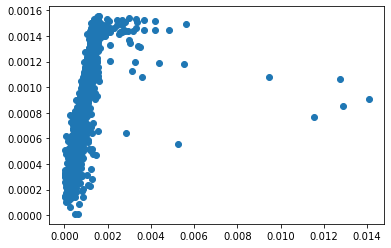

In [18]:
plt.scatter(
    p/peTotal, 
    gbmForP.predict(
        np.stack(
            (peMean, peStd, peTimeMean, peTimeStd),
            axis=1
        )
    )
)
plt.show()